# Introduction

The National Agriculture Imagery Program (NAIP) provides high-resolution aerial imagery of the United States to the public via an [Amazon Web Services (AWS) S3 bucket](https://aws.amazon.com/public-datasets/naip/).

Essentially, the US is broken into a grid of cells called quadrangles, and the images NAIP provides correspond to cells in this grid. Thus, to get an image containing a specific landmark, one must first figure out in which quadrangle it is located. The quadrangle naming conventions are standardized based on latitude and longitude coordinates. Here, we use this fact to automate the process of downloading NAIP images based on simple names like "Golden Gate Bridge, CA" with the following procedure:

1. Use a geolocator to convert landmark names like "Golden Gate Bridge, CA" to (latitude, longitude) coordinates.
2. Calculate the quadrangle identifier based on the coordinates.
3. Search the NAIP bucket manifest for an RGB image with the corresponding identifier.
4. Download the RGB image locally.

Step 2 is handled by a function `get_doqq_id` defined below while the rest of the steps are wrapped up into a `download_landmark` function.

# Prerequisites

## AWS CLI
In addition to the Python libraries imported below, you should have the [AWS command-line interface](https://docs.aws.amazon.com/cli/latest/userguide/installing.html) installed and configured if you want to use the NAIP bucket. Unfortunately, because of a [permission issue](https://github.com/mapbox/s3pay/issues/1), the AWS library `boto3` won't work with the NAIP bucket. So, download the entire NAIP manifest with a shell command like

```shell
aws s3api get-object --bucket aws-naip --key manifest.txt --request-payer requester naip/manifest.txt
```

## Quadrangle and DOQQ Primer

The manifest lists all the files hosted on the NAIP bucket. The [naming convetion](https://lta.cr.usgs.gov/naip_full_res.html#naip_entity_id) of each file is based on the [USGS quadrangle standards](https://topomaps.usgs.gov/drg/drg_name.html#hdr%209). As an example, the quadrangle called `3712213` is located in a swath of the earth encompassing latitude degrees `37` (the first two digits of the quadrangle identifier) to `38` and longitude degrees `-122` (the next three digits) to `-123`. Then, this `1x1` degree block is then broken down further into an `8x8` grid with the southeast corner of the grid corresponding to `(37, -122)` and the northwest corner to `(38, -123)`. Thus, each grid cell or qaudrangle covers `0.125` degrees of longitude and latitude. By NAIP conventions, the indexing of cells within the `1x1` degree block starts in the northwest corner with index `1`, and the index corresponds to the last two digits of the identifier. In our example, the index `13` corresponds to the cell in the second row and fifth column of the `1x1` degree block.

`grep` through the manifest to find all files corresponding to the example quadrangle `3712213`.

```shell
grep "3712213" naip/manifest.txt
```

returns a list of files like

```shell
ca/2012/1m/fgdc/37122/m_3712213_ne_10_1_20120520.txt
ca/2012/1m/fgdc/37122/m_3712213_nw_10_1_20120520.txt
ca/2012/1m/fgdc/37122/m_3712213_se_10_1_20120520.txt
ca/2012/1m/fgdc/37122/m_3712213_sw_10_1_20120520.txt
ca/2012/1m/rgb/37122/m_3712213_ne_10_1_20120520.tif
ca/2012/1m/rgb/37122/m_3712213_nw_10_1_20120520.tif
ca/2012/1m/rgb/37122/m_3712213_se_10_1_20120520.tif
ca/2012/1m/rgb/37122/m_3712213_sw_10_1_20120520.tif
ca/2012/1m/rgbir/37122/m_3712213_ne_10_1_20120520.tif
ca/2012/1m/rgbir/37122/m_3712213_nw_10_1_20120520.tif
ca/2012/1m/rgbir/37122/m_3712213_se_10_1_20120520.tif
ca/2012/1m/rgbir/37122/m_3712213_sw_10_1_20120520.tif
ca/2014/1m/fgdc/37122/m_3712213_ne_10_1_20140608.txt
ca/2014/1m/fgdc/37122/m_3712213_nw_10_1_20140608.txt
ca/2014/1m/fgdc/37122/m_3712213_se_10_1_20140613.txt
ca/2014/1m/fgdc/37122/m_3712213_sw_10_1_20140613.txt
ca/2014/1m/rgb/37122/m_3712213_ne_10_1_20140608.tif
ca/2014/1m/rgb/37122/m_3712213_nw_10_1_20140608.tif
ca/2014/1m/rgb/37122/m_3712213_se_10_1_20140613.tif
ca/2014/1m/rgb/37122/m_3712213_sw_10_1_20140613.tif
ca/2014/1m/rgbir/37122/m_3712213_ne_10_1_20140608.tif
ca/2014/1m/rgbir/37122/m_3712213_nw_10_1_20140608.tif
ca/2014/1m/rgbir/37122/m_3712213_se_10_1_20140613.tif
ca/2014/1m/rgbir/37122/m_3712213_sw_10_1_20140613.tif
ca/2016/.6m/fgdc/37122/m_3712213_ne_10_h_20160625.txt
ca/2016/.6m/fgdc/37122/m_3712213_nw_10_h_20160625.txt
ca/2016/.6m/fgdc/37122/m_3712213_se_10_h_20160625.txt
ca/2016/.6m/fgdc/37122/m_3712213_sw_10_h_20160625.txt
ca/2016/.6m/rgb/37122/m_3712213_ne_10_h_20160625.tif
ca/2016/.6m/rgb/37122/m_3712213_nw_10_h_20160625.tif
ca/2016/.6m/rgb/37122/m_3712213_se_10_h_20160625.tif
ca/2016/.6m/rgb/37122/m_3712213_sw_10_h_20160625.tif
ca/2016/.6m/rgbir/37122/m_3712213_ne_10_h_20160625.tif
ca/2016/.6m/rgbir/37122/m_3712213_nw_10_h_20160625.tif
ca/2016/.6m/rgbir/37122/m_3712213_se_10_h_20160625.tif
ca/2016/.6m/rgbir/37122/m_3712213_sw_10_h_20160625.tif
```

Notice a few things about the files in the manifest. First, files are grouped by state. It happens that the quadrangle picked corresponds exclusively to California, but some quadrangles might encompass multiple states. Second, there are multiple years of data (`2012`, `2014`, and `2016` in this case). Then, the `1m` or `.6m` directiories correspond to the resolution of the images (e.g. `1` meter per pixel). The next directory tells what type of data is stored there such as `rgb` for RGB images or `fgdc` for metadata text files. The rest of the path is based on the quadrangle and other properties of the image data. 

Also note the intercardinal directions in the filenames such as `nw` (northwest). With NAIP data, each quadrangle tile is broken up into four chunks or quadrants. Each chunk is called a **digital ortho quarter quad** (**DOQQ**) tile since it covers a fourth of specified the quadrangle. If you want data for an entire city, you'll probably want to download all chunks of a quadrangle, but if you're interested in a specific landmark like a building, then you'll need to figure out which chunk contains the landmark as done below.

The rest of this notebook shows how to convert a (latitude, longitude) pair into the specific DOQQ that contains the pair. Further, we automate the process of inputting simple landmark names like "Golden Gate Bridge, CA" and outputting a subset of the NAIP image that contains the landmark.

# Code

## Dependencies

In [1]:
import rasterio
from rasterio.mask import mask as rio_mask
from rasterio.features import rasterize
from geopy.geocoders import GoogleV3
from shapely.geometry import box
from pyproj import Proj

import pprint
import os
import subprocess

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## DOQQ calculator

The function `get_doqq_id` converts an input (latitude, longitude) pair into the corresponding DOQQ identifier. We assume that we are are working with US data as provided by NAIP on AWS, so a key assumption is that latitude is positive and longitude is negative. This makes it easier to find the correct row and column indicies within the `1`-degree `8x8` grid. Adapting this function for other parts of the globe is left as an exercise for the reader.

In [2]:
def get_doqq_id(lat, lon):
    
    ## Assume 8x8 grid
    grid_size = 8
    grid_step = 1 / grid_size 
    
    ## Find index in 1-degree block (8x8 grid)
    ## NOTE: Quadrangles are 1-indexed
    lat_decimals = lat - int(lat)
    lon_decimals = lon - int(lon)
    row_ndx = (grid_size - 1) - int(lat_decimals / grid_step)
    col_ndx = (grid_size - 1) + int(lon_decimals / grid_step)
    ndx = 1 + np.ravel_multi_index((row_ndx , col_ndx), (grid_size, grid_size))
    
    ## Find quadrant (nw, ne, sw, se)
    lon_upper = int(lon) - grid_step * (grid_size - col_ndx - 1)
    lon_lower = int(lon) - grid_step * (grid_size - col_ndx)
    lat_upper = int(lat) + grid_step * (grid_size - row_ndx)
    lat_lower = int(lat) + grid_step * (grid_size - row_ndx - 1)
    lon_mid = (lon_upper + lon_lower) / 2
    lat_mid = (lat_upper + lat_lower) / 2
    if lat > lat_mid:
        quadrant = 'n'
    else:
        quadrant = 's'
        
    if lon > lon_mid:
        quadrant = quadrant + 'e'
    else:
        quadrant = quadrant + 'w'
    
    ## Format output string
    lat_str = str(int(lat))
    if abs(lon) < 100:
        lon_str = '0' + str(abs(int(lon)))
    else:
        lon_str = str(abs(int(lon)))
    
    if ndx < 10:
        ndx_str = '0' + str(ndx)
    else:
        ndx_str = str(ndx)
    
    return lat_str + lon_str + ndx_str + '_' + quadrant

Then, it's simple enough to use this function to convert landmark names like 'Statue of Liberty, NY' into the corresponding NAIP image that contains it. First, use a geolocating service to convert the landmark into latitude, longitude coordinates. Then, use 
`get_doqq_id` to convert the coordinate to an identifier. Finally, just search the NAIP manifest downloaded previously for the identifier. These steps are wrapped up in the function below.

In [3]:
def download_landmark(place, img_dir = '', manifest_path = 'naip/manifest.txt'):
    
    ## Get DOQQ ID
    api_key = os.environ.get('GOOG_GEOLOCATOR_API_KEY')
    geolocator = GoogleV3(api_key)
    loc = geolocator.geocode(place)
    lat, lon = loc.latitude, loc.longitude
    doqq_id = get_doqq_id(lat, lon)

    ## Search for ID in manifest
    with open(manifest_path, 'r') as manifest:
        for line in manifest:
            if '/rgb/' in line:
                if doqq_id in line:
                    naip_key = line.strip()
                    break

    ## Download image if it doesn't exist
    img_path = os.path.join(img_dir, naip_key.split('/')[-1])
    aws_cmd = 'aws s3api get-object --bucket aws-naip --key {} --request-payer requester {}'
    aws_cmd = aws_cmd.format(naip_key, img_path)
    if os.path.isfile(img_path):
        print('Skipping {}\n'.format(naip_key))
    else:
        print('Downloading {} with the following command:\n{}\n'.format(naip_key, aws_cmd))
        subprocess.run(aws_cmd, shell = True)
    return img_path, lat, lon

We can run a test case.

In [4]:
place = 'Statue of Liberty, NY'
img_dir = 'naip/img'
img_path, lat, lon = download_landmark(place, img_dir)
print(img_path, lat, lon)

aws s3api get-object --bucket aws-naip --key nj/2013/1m/rgb/40074/m_4007424_ne_18_1_20130802.tif --request-payer requester naip/img/m_4007424_ne_18_1_20130802.tif

naip/img/m_4007424_ne_18_1_20130802.tif 40.6892494 -74.04450039999999


However, NAIP images are somewhat large and so you might have to go hunting through the image to find the landmark. With a little more work, we can automate the process of extracting a small subset of the downloaded images centered around the landmark.

Skipping nj/2013/1m/rgb/40074/m_4007424_ne_18_1_20130802.tif

aws s3api get-object --bucket aws-naip --key md/2013/1m/rgb/38077/m_3807708_se_18_1_20130924.tif --request-payer requester naip/img/m_3807708_se_18_1_20130924.tif

aws s3api get-object --bucket aws-naip --key az/2013/1m/rgb/36114/m_3611459_sw_11_1_20130605.tif --request-payer requester naip/img/m_3611459_sw_11_1_20130605.tif

aws s3api get-object --bucket aws-naip --key ca/2012/1m/rgb/37122/m_3712213_nw_10_1_20120520.tif --request-payer requester naip/img/m_3712213_nw_10_1_20120520.tif



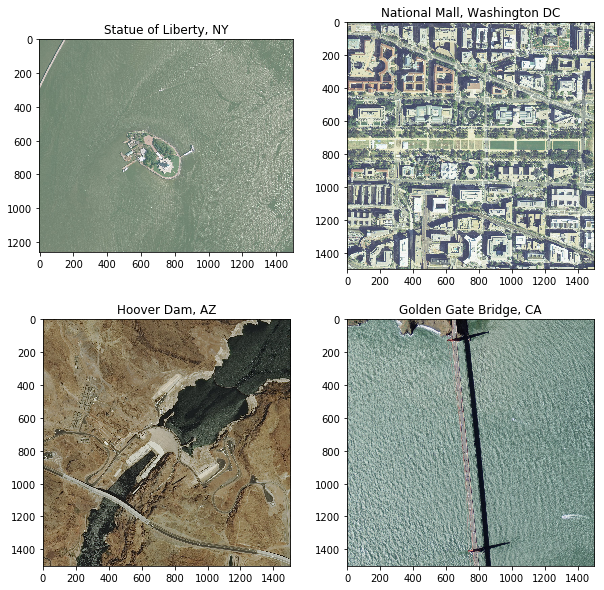

In [5]:
places = [
    'Statue of Liberty, NY',
    'National Mall, Washington DC',
    'Hoover Dam, AZ',
    'Golden Gate Bridge, CA'
]
img_dir = 'naip/img'
mask_len = 1500 # meters
fig, axes = plt.subplots(2, 2, figsize = (10, 10))
axes = axes.flatten()

for i, place in enumerate(places):
    img_path, lat, lon = download_landmark(place, img_dir)
    with rasterio.open(img_path) as src:
        
        ## Project landmark lat,lon
        proj = Proj(src.crs)
        x,y = proj(lon, lat)

        ## Make mask centered at the landmark
        mask_shape = box(x-mask_len/2, y-mask_len/2, x+mask_len/2, y+mask_len/2)
        mask = {'type': 'Polygon', 'coordinates': [list(mask_shape.exterior.coords)]}

        ## Extract only the data within the mask
        img, transform = rio_mask(src, [mask], crop = True)
        img = np.moveaxis(img, 0, 2) # channels last
        
        axes[i].set_title(place)
        axes[i].imshow(img)
fig.savefig('four_us_landmarks.png', bbox_inches = 'tight')

If you don't recognize the landmarks from the NAIP images above, check it out on Google Maps satellite view and verify we are looking at the correct locations. 

When working with NAIP data yourself, you might want to modify the given code to download the metadata and RGB+IR (infrared) images or restrict the search to certain years or resolutions of data.